In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [2]:
# Load the dataset
df = pd.read_excel('internet.xlsx')

In [3]:
# MF: male = 0, female = 1
# App: Health =0, Automotive = 1, Fashion = 2
# Category: Non-alcoholic = 0. Clothing = 1, Beauty = 2, Mid-range car = 3, Beer and Wine = 4, Restaurants =5, 
# Category (cont'd): Prescription medicine = 6, Luxury cars = 7
# Click: No = 0, Yes = 1
# min = interaction_with_app

In [4]:
df.head()

,MF,App,Category,Click,min
0,0,0,0,0,1
1,0,0,0,0,2
2,0,0,0,0,3
3,0,0,0,1,1
4,1,0,0,1,1


In [5]:
df.describe()

,MF,App,Category,Click,min
count,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.28500,0.380000,1.900000,0.48000,2.691000
std,0.45164,0.732213,2.191986,0.49985,2.897225
min,0.00000,0.000000,0.000000,0.00000,0.000000
25%,0.00000,0.000000,0.000000,0.00000,1.000000
50%,0.00000,0.000000,1.000000,0.00000,1.000000
75%,1.00000,0.000000,4.000000,1.00000,4.250000
max,1.00000,2.000000,7.000000,1.00000,15.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MF        1000 non-null   int64
 1   App       1000 non-null   int64
 2   Category  1000 non-null   int64
 3   Click     1000 non-null   int64
 4   min       1000 non-null   int64
dtypes: int64(5)
memory usage: 39.2 KB


In [7]:
X = df.drop(['MF'], axis =1)
X

,App,Category,Click,min
0,0,0,0,1
1,0,0,0,2
2,0,0,0,3
3,0,0,1,1
4,0,0,1,1
...,...,...,...,...
995,2,2,0,3
996,2,2,1,4
997,2,2,1,1
998,2,2,1,1


In [8]:
y = df.MF

In [9]:
# Standardize features (mean = 0, variance =1)

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [10]:
# Setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)

In [11]:
# function to get cross validation scores
# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal.
# F1 = 2 * (precision * recall) / (precision + recall)
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='f1')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [12]:
cla = SGDClassifier(loss = 'hinge', alpha=0.0001, l1_ratio=0.15, class_weight = 'balanced')
cla.fit(X_train, y_train)

SGDClassifier(class_weight='balanced')

In [13]:
# get cross val scores
get_cv_scores(cla)

print('Train Score: ', cla.score(X_train, y_train))
print('Test Score: ', cla.score(X_test, y_test))

CV Mean:  0.5769041474238895
STD:  0.05540483689529647


Train Score:  0.6853333333333333
Test Score:  0.66


In [14]:
# find optimal alpha with grid search
alpha = [1e-10, 1e-5, 1, 1e5, 1e10]
l1_ratio = [0.1, 0.3, 0.6, 0.9]
loss = ['hinge', 'log']
param_grid = dict(alpha=alpha, l1_ratio = l1_ratio, loss = loss)

grid = GridSearchCV(estimator=cla, param_grid=param_grid, scoring='f1')
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.5586758475078205
Best Params:  {'alpha': 1, 'l1_ratio': 0.9, 'loss': 'log'}


In [15]:
cla = SGDClassifier(loss = 'log', alpha=1, l1_ratio=0.3, class_weight = 'balanced')
cla.fit(X_train, y_train)

SGDClassifier(alpha=1, class_weight='balanced', l1_ratio=0.3, loss='log')

In [16]:
# get cross val scores
get_cv_scores(cla)

print('Train Score: ', cla.score(X_train, y_train))
print('Test Score: ', cla.score(X_test, y_test))

CV Mean:  0.48256154414691005
STD:  0.10812089778251398


Train Score:  0.8373333333333334
Test Score:  0.832


In [17]:
cla.intercept_

array([-0.1486988])

In [18]:
cla.coef_

array([[ 0.00444342, -0.04353713,  0.15737228,  0.00705107]])

In [19]:
cla.coef = np.squeeze(cla.coef_)
cla.coef

array([ 0.00444342, -0.04353713,  0.15737228,  0.00705107])

In [20]:
# Sequency of the terms: a, b, c, d

terms = ['App', 'Category', 'Click', 'min']

In [21]:
# match column names to coefficients
for coef, col in enumerate(terms):
    print(f'{col}:  {cla.coef[coef]}')

App:  0.004443416619003108
Category:  -0.04353713139135449
Click:  0.15737228031855516
min:  0.007051071196616573


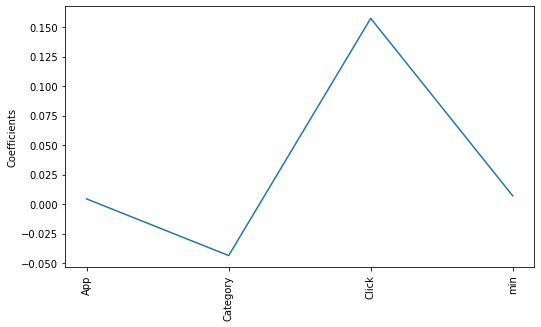

In [22]:
_ = plt.figure(figsize=[8.4, 4.8])
_ = plt.plot(range(len(terms)), cla.coef)
_ = plt.xticks(range(len(terms)), terms, rotation=90)
_ = plt.ylabel('Coefficients')
plt.show()

In [23]:
# Predict a user who interacts with Health app (App= 0,) for one min (min=1), and clicks (click =1) on 
# Restraurant(catagory =5). This user is a femal as the model predicted.

cla.predict([[0,0,5,1]])

array([1], dtype=int64)